In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

from bs4 import BeautifulSoup
import requests
import re

import os

from sklearn.externals import joblib 

Running on PyMC3 v3.8


In [38]:
def exp_model(x, y):
    
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    with pm.Model() as model:
        
         # Priors for unknown model parameters
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=1)

        # Expected value of outcome
        mu = alpha*pm.math.exp(beta*x)

        # Likelihood (sampling distribution) of observations
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
    return model
    
def sig_model(x, y):
    
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    with pm.Model() as model:
        
         # Priors for unknown model parameters
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
        sigma = pm.HalfNormal('sigma', sigma=1)

        # Expected value of outcome
        mu = alpha/(1+pm.math.exp(-(beta[0]*x+beta[1])))

        # Likelihood (sampling distribution) of observations
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
    return model

def train_model(model, draws=5000, tune=5000, progressbar=True):
    
    with model:
        
         # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
        #start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        #step = pm.NUTS()
        
        trace = pm.sample(
            draws=draws,# step=step, start=start,
            tune=tune,
            random_seed=42, progressbar=True#, cores=4
        )
        
    return trace
        
def predict_model(model, trace, samples):
    
    with model:
        
        y_hat = pm.sample_posterior_predictive(trace, samples=samples)
        
    return y_hat['y_obs']

# arbitrary country
def get_country(country, start_date='', end_date='', min_cases=10):

    url = 'https://www.worldometers.info/coronavirus/country/'+country.lower()+'/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    test= soup.find('script', text=re.compile('Total Coronavirus Cases'))
    save_stuff = False
    for line in test.get_text().split('\n'):
        if 'text' in line:
            if 'Linear Scale' in line or 'Total Coronavirus Cases' in line:
                save_stuff = True
            else:
                save_stuff = False
        if 'categories' in line:
            if save_stuff:
                categories = line.split(',')
                categories[0] = categories[0][25:]
                categories = categories[:-1]
                categories[-1] = categories[-1].strip('}').strip(' ').strip(']')
                categories = [x.strip('"') for x in categories]
        if 'data' in line:
            if save_stuff:
                data = line.split(',')
                data[0] = data[0][19:]
                data = data[:-1]
                data[-1] = data[-1].strip(']').strip('}').strip(' ').strip(']')
                data = [int(x) for x in data]
                
    start = np.where(np.array(categories)==start_date)[0]
    if len(start)==0:
        start = 0
    else:
        start = start[0]
        
    end = np.where(np.array(categories)==end_date)[0]
    if len(end)==0:
        end = len(categories)-1
    else:
        end = end[0]
    
    dates = categories[start:end+1]
    data = data[start:end+1]
    
    if max(data)<min_cases:
        print('Warning, {:d} cases has not occured in this date range.')
    else:
        min_start = np.where(np.array(data)>=min_cases)[0][0]
        data = data[min_start:]
        dates = dates[min_start:]
    
    return dates, np.arange(1, len(data)+1), np.array(data)

def scale_data(x, y):
    x_train = np.array(x[:-3])
    y_train = np.array(y[:-3])

    x_test = np.array(x[-3:])
    y_test = np.array(y[-3:])

    # rescale y
    scaley = MinMaxScaler(feature_range = (0.1, 0.8))
    y_scale = scaley.fit_transform(y_train.reshape(-1,1)).flatten()

    # rescale x?
    scalex = MinMaxScaler()
    x_scale = scalex.fit_transform(x_train.reshape(-1,1)).flatten()
    
    return x_train, y_train, x_scale, y_scale, x_test, y_test, scaley, scalex

In [7]:
country = 'Italy'
min_cases=100
dates, x, y = get_country(country, min_cases=min_cases)#, 'Mar 02', 'Mar 17')

x_train, y_train, x_scale, y_scale, x_test, y_test, scaley, scalex = scale_data(x, y)

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
for item in zip(x_train, y_train):
    print(item)

(1, 157)
(2, 229)
(3, 323)
(4, 470)
(5, 655)
(6, 889)
(7, 1128)
(8, 1701)
(9, 2036)
(10, 2502)
(11, 3089)
(12, 3858)
(13, 4636)
(14, 5883)
(15, 7375)
(16, 9172)
(17, 10149)
(18, 12462)
(19, 15113)
(20, 17660)
(21, 21157)
(22, 24747)
(23, 27980)
(24, 31506)
(25, 35713)


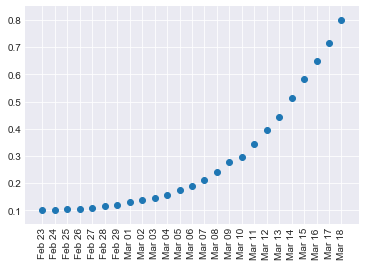

In [12]:
plt.scatter(x_scale, y_scale)
plt.xticks(x_scale, dates, rotation=90)
plt.show()

In [13]:
exp = exp_model(x_scale, y_scale)
sig = sig_model(x_scale, y_scale)
exp_trace = train_model(exp, draws=5000, tune=5000)
sig_trace = train_model(sig, draws=5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 18 divergences: 100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:33<00:00, 1192.69draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6672753283304383, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 892 divergences: 100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:50<00:00, 79.94d

In [19]:
last = len(x)
num_days = 7
extend = np.arange(last+1, last+num_days+1)
x_updated = np.append(x, extend)
x_updated_scaled = scalex.transform(x_updated.reshape(-1, 1)).flatten()
y_updated = np.empty(x_updated.shape)

exp_updated = exp_model(x_updated_scaled, y_updated)
sig_updated = sig_model(x_updated_scaled, y_updated)

y_exp = predict_model(exp_updated, exp_trace, 1000)
y_sig = predict_model(sig_updated, sig_trace, 1000)

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 914.02it/s]


In [22]:
y_exp_avg = np.mean(y_exp, axis=0).reshape(-1,1)
y_exp_std = 2*np.std(y_exp, axis=0).reshape(-1,1)

y_sig_avg = np.mean(y_sig, axis=0).reshape(-1,1)
y_sig_std = 2*np.std(y_sig, axis=0).reshape(-1,1)

y_exp_high = scaley.inverse_transform(y_exp_avg+y_exp_std).flatten()
y_exp_low = scaley.inverse_transform(y_exp_avg-y_exp_std).flatten()

y_sig_high = scaley.inverse_transform(y_sig_avg+y_sig_std).flatten()
y_sig_low = scaley.inverse_transform(y_sig_avg-y_sig_std).flatten()


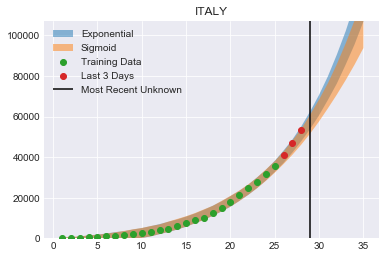

In [36]:
plt.fill_between(x_updated, y_exp_high, y_exp_low, alpha = 0.5, label='Exponential')
plt.fill_between(x_updated, y_sig_high, y_sig_low, alpha = 0.5, label='Sigmoid')
plt.scatter(x_train, y_train, label='Training Data')
plt.scatter(x_test, y_test, label='Last 3 Days')
plt.vlines(last+1, -0.5, max(y)+1*max(y), label='Most Recent Unknown')
plt.ylim([-0.5, max(y)+1*max(y)])
plt.legend(loc='upper left')
plt.title(country.upper())
plt.show()


In [24]:

pm.save_trace(exp_trace, directory = 'traces/'+country, overwrite=True)

'traces'

In [33]:
tr_path = os.path.join('traces', country)
if not os.path.isdir(tr_path):
    print('Directory for {:s} does not exist. Creating now.'.format(country.title()))
    os.mkdir(tr_path)
    os.mkdir(os.path.join(tr_path, 'exp'))
    os.mkdir(os.path.join(tr_path, 'sig'))
else:
    print('Directory for {:s} already exists. Will overwrite current traces.'.format(country.title()))
    
pm.save_trace(exp_trace, directory = os.path.join(tr_path, 'exp'), overwrite=True)
pm.save_trace(sig_trace, directory = os.path.join(tr_path, 'sig'), overwrite=True)

Directory for Italy does not exist. Creating now.


'traces\\Italy\\sig'

In [35]:
# save scalers also
joblib.dump(scalex, os.path.join(tr_path,'scalex.pkl'))
joblib.dump(scaley, os.path.join(tr_path, 'scaley.pkl'))

['traces\\Italy\\scaley.pkl']

In [43]:
# loop over multiple countries
country_list = ['Italy', 'Germany', 'China', 'Spain', 'Canada', 'US']
min_cases = 100
for country in country_list:
    
    print(country.upper())
    print('-'*len(country))

    # get data from website
    dates, x, y = get_country(country, min_cases=min_cases)#, 'Mar 02', 'Mar 17')
    
    # rescale
    x_train, y_train, x_scale, y_scale, x_test, y_test, scaley, scalex = scale_data(x, y)
    
    # produce fits
    exp = exp_model(x_scale, y_scale)
    sig = sig_model(x_scale, y_scale)
    exp_trace = train_model(exp, draws=5000, tune=5000)
    sig_trace = train_model(sig, draws=5000, tune=5000)
    
    # save to file
    tr_path = os.path.join('traces', country.lower())
    if not os.path.isdir(tr_path):
        print('Directory for {:s} does not exist. Creating now.'.format(country.title()))
        os.mkdir(tr_path)
        os.mkdir(os.path.join(tr_path, 'exp'))
        os.mkdir(os.path.join(tr_path, 'sig'))
    else:
        print('Directory for {:s} already exists. Will overwrite current traces.'.format(country.title()))

    pm.save_trace(exp_trace, directory = os.path.join(tr_path, 'exp'), overwrite=True)
    pm.save_trace(sig_trace, directory = os.path.join(tr_path, 'sig'), overwrite=True)
    
    # save scalers also
    joblib.dump(scalex, os.path.join(tr_path,'scalex.pkl'))
    joblib.dump(scaley, os.path.join(tr_path, 'scaley.pkl'))
    
    # also save fitting data so comparing apples to apples
    joblib.dump(dates, os.path.join(tr_path,'dates.pkl'))
    joblib.dump(x, os.path.join(tr_path,'x.pkl'))
    joblib.dump(y, os.path.join(tr_path,'y.pkl'))
    

ITALY
-----


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 18 divergences: 100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:33<00:00, 1193.17draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.667275328

Directory for Italy already exists. Will overwrite current traces.
GERMANY
-------


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 8 divergences: 100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [00:36<00:00, 1086.07draws/s]
The acceptance probability does not match the target. It is 0.912908208018798, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Ther

Directory for Germany does not exist. Creating now.
CHINA
-----


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [00:27<00:00, 1430.73draws/s]
The acceptance probability does not match the target. It is 0.8813338304586289, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multipro

Directory for China does not exist. Creating now.
SPAIN
-----


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 23 divergences: 100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:39<00:00, 1008.63draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or rep

Directory for Spain does not exist. Creating now.
CANADA
------


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 132 divergences: 100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [00:35<00:00, 1125.85draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.683472

Directory for Canada does not exist. Creating now.
US
--


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 14 divergences: 100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [00:42<00:00, 939.09draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8807133770560717, but should be close to 0.8. Try to increase the number of tuning steps.
T

Directory for Us does not exist. Creating now.
